# Methodological Foundation of a Numerical Taxonomy of Urban Form

This notebook serves as a template for morphometric assessment and generation of a taxonomy.

## Reproducible Python code to generate taxonomy

Complete morphometrics assessment from input data to taxonomy.

Input data:
 - building footprints
 - street network
 
This notebook is running the analysis on the sample of the data used in Prague case study. You can replace the sample with your own data, assuming that they are cleaned to a required standard. 

The sample is saved in `../files/sample.gpkg` with two layers named `buildings` and `streets`. `buildings` are Polygons, whilst `streets` are LineStrings.

Buildings data contain a single attribute column:

- `height` - building height in meters.

This notebook has been updated to work with `momepy` 0.5 and `geopandas` 0.10. The original work has been carried out using `momepy` 0.3 within the Docker container `darribas/gds_py:5.0`.

All data generated throughout the method are saved to files (unless commented out).

First we import all required libraries.

In [ ]:
import warnings

import geopandas as gpd
import libpysal
import mapclassify

import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from tqdm.auto import tqdm
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy

# we are using bleeding edge software that emits some warnings irrelevant for the current runtime
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
warnings.filterwarnings('ignore', message='.*overflow encountered*')
warnings.filterwarnings('ignore', message='.*index_parts defaults to True')
warnings.filterwarnings('ignore', message='.*`op` parameter is deprecated*')

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check the input data

We load buildings and create unique ID.

In [2]:
path = r"C:\Users\edoar\OneDrive\Desktop\test\bl2.shp"
layer = "bl2"
buildings = gpd.read_file(path, layer=layer)

In [3]:
buildings

,fid,source,id,height,var,region,geometry
0,1.0,osm,91445666,1.707255,0.279685,FRA,"POLYGON ((4.90638 43.93883, 4.90633 43.93883, ..."
1,2.0,osm,91454877,1.790354,0.495201,FRA,"POLYGON ((4.90633 43.93883, 4.90638 43.93883, ..."
2,3.0,osm,91447906,4.849935,0.793224,FRA,"POLYGON ((4.90638 43.93877, 4.90638 43.93872, ..."
3,4.0,osm,91447915,6.187273,2.629897,FRA,"POLYGON ((4.9063 43.93841, 4.90645 43.93841, 4..."
4,5.0,osm,91452732,7.221760,1.860933,FRA,"POLYGON ((4.90661 43.93903, 4.90669 43.93902, ..."
...,...,...,...,...,...,...,...
39328,39329.0,osm,83749935,6.164693,1.097927,FRA,"POLYGON ((4.75896 43.92834, 4.7591 43.92838, 4..."
39329,39330.0,ms,France_120222130_347775,0.047072,0.002646,FRA,"POLYGON ((4.74978 43.92874, 4.74984 43.92878, ..."
39330,39331.0,ms,France_120222130_110267,0.022327,0.000106,FRA,"POLYGON ((4.74968 43.92714, 4.74968 43.92717, ..."
39331,39332.0,ms,France_120222130_12710,0.017826,0.000015,FRA,"POLYGON ((4.74979 43.92706, 4.74979 43.92709, ..."


In [4]:
buildings = buildings.explode(ignore_index=True)
buildings

,fid,source,id,height,var,region,geometry
0,1.0,osm,91445666,1.707255,0.279685,FRA,"POLYGON ((4.90638 43.93883, 4.90633 43.93883, ..."
1,2.0,osm,91454877,1.790354,0.495201,FRA,"POLYGON ((4.90633 43.93883, 4.90638 43.93883, ..."
2,3.0,osm,91447906,4.849935,0.793224,FRA,"POLYGON ((4.90638 43.93877, 4.90638 43.93872, ..."
3,4.0,osm,91447915,6.187273,2.629897,FRA,"POLYGON ((4.9063 43.93841, 4.90645 43.93841, 4..."
4,5.0,osm,91452732,7.221760,1.860933,FRA,"POLYGON ((4.90661 43.93903, 4.90669 43.93902, ..."
...,...,...,...,...,...,...,...
39331,39329.0,osm,83749935,6.164693,1.097927,FRA,"POLYGON ((4.75896 43.92834, 4.7591 43.92838, 4..."
39332,39330.0,ms,France_120222130_347775,0.047072,0.002646,FRA,"POLYGON ((4.74978 43.92874, 4.74984 43.92878, ..."
39333,39331.0,ms,France_120222130_110267,0.022327,0.000106,FRA,"POLYGON ((4.74968 43.92714, 4.74968 43.92717, ..."
39334,39332.0,ms,France_120222130_12710,0.017826,0.000015,FRA,"POLYGON ((4.74979 43.92706, 4.74979 43.92709, ..."


<Axes: >

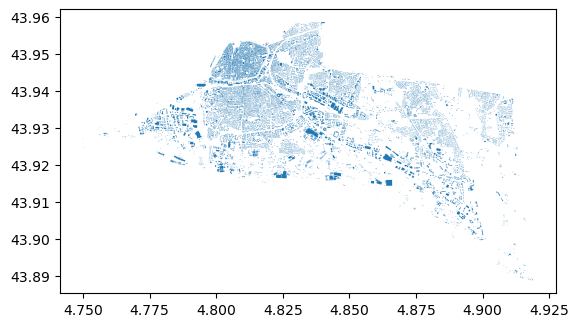

In [5]:
buildings.plot()

Let's create a persistent unique identifier for each building.

In [6]:
buildings["uID"] = range(len(buildings))

In [7]:
buildings = buildings.to_crs(epsg=32633)

In [7]:
print(buildings.crs)

EPSG:32633


### Generate additional morphometric elements

Before we can start morhometrics we have to generate additional elements - tessellation and tessellation based blocks.

#### Morphological tessellation

Check input for tessellation. If the input data is clean, the check will result in zeros. The data does not have to be 100% clean (all 0). For example `Split features` may not cause any issue. 

In [8]:
check = mm.CheckTessellationInput(buildings)

Collapsed features  : 50
Split features      : 58
Overlapping features: 0


Generate tessellation limited to 100 m buffer. Beware, it is memory demanding.

**Note:** You may find that this step requires more memory that you are able to provide. In that case, you may consider using an [enclosed tessellation](http://docs.momepy.org/en/stable/user_guide/elements/enclosed.html) method instead. However, that would require minor adaptation of the code below as well.

In [9]:
limit = mm.buffered_limit(buildings, 100)

tessellation = mm.Tessellation(buildings, "uID", limit, verbose=False)
tessellation = tessellation.tessellation

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2640492488.py:3: FutureWarning: Class based API like `momepy.Tessellation` is deprecated. Replace it with `momepy.morphological_tessellation` or `momepy.enclosed_tessellation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation = mm.Tessellation(buildings, "uID", limit, verbose=False)
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2640492488.py:3: UserWarning: Tessellation does not fully match buildings. 56 element(s) collapsed during generation - unique_id: {4867, 22019, 14597, 11527, 12041, 37136, 6162, 15646, 16948, 2101, 21302, 2113, 15937, 3403, 12365, 29524, 32854, 32857, 32860, 15712, 34658, 24699, 3454, 6785, 6019, 4234, 6027, 34958, 2453, 150, 152, 2459, 2460, 157, 2464, 24736, 10916, 167, 2471, 8624, 4274, 12728, 12984, 27323, 12732, 29627, 32956, 36557, 4320, 26083, 27619, 4328, 3064, 35324, 3070, 20223}.
  tessellation = mm.Tessellation(buildings, "uID", limit, v

In [10]:
tessellation

,uID,geometry
952,956,"POLYGON ((-309950.168 4909187.698, -309950.069..."
951,955,"POLYGON ((-309918.998 4909215.416, -309919.149..."
914,918,"POLYGON ((-310181.218 4909272.387, -310181.509..."
924,928,"POLYGON ((-310138.683 4909262.113, -310134.333..."
954,958,"POLYGON ((-309965.812 4909226.956, -309966.393..."
...,...,...
18425,18462,"POLYGON ((-316274.345 4917676.832, -316274.948..."
19386,19423,"POLYGON ((-316584.539 4917314.115, -316584.617..."
19393,19430,"POLYGON ((-316575.924 4917316.451, -316575.961..."
19395,19432,"POLYGON ((-316545.463 4917410.896, -316546.049..."


<Axes: >

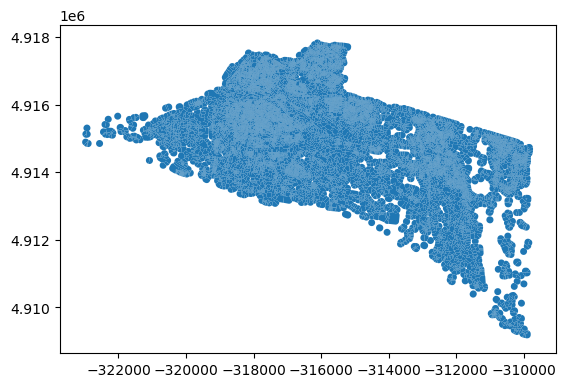

In [11]:
tessellation.plot()

We save tessellation to file. Note that this file is not part of the repository but can be fully created using the input sample and this notebook.

In [12]:
tessellation.to_file(r"C:\Users\edoar\OneDrive\Desktop\test\geometry.gpkg", layer="tessellation")

### Tessellation based blocks

To generate tessellation based blocks we also need street network, therefore we need to read it to GeoDataFrame first.

In [13]:
path = r"C:\Users\edoar\OneDrive\Desktop\test\Avignon_Roads.gpkg"
layer = "Avignon_roads"

In [14]:
streets = gpd.read_file(path, layer=layer)

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: This version of GeoPackage user_version=0x000028A0 (10400, v1.4.0) on 'C:\Users\edoar\OneDrive\Desktop\test\Avignon_Roads.gpkg' may only be partially supported
  return ogr_read(


In [15]:
streets = streets.explode()

In [16]:
streets = streets.to_crs(epsg=32633)

<Axes: >

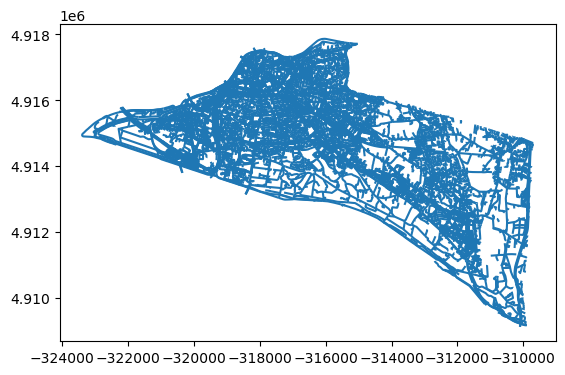

In [17]:
streets.plot()

To create blocks within the full `limit`, it is always safer to extend street network to the edge of the limit.

In [18]:
extended = mm.extend_lines(streets, tolerance=120, target=gpd.GeoSeries([limit.boundary]), barrier=buildings)

In [ ]:
blocks, tessellation_id = momepy.generate_blocks(
    tessellation=tessellation,
    edges=extended,
    buildings=buildings
)

In [19]:
blocks = mm.Blocks(tessellation, edges=extended, buildings=buildings, id_name='bID', unique_id='uID')
blocks_df = blocks.blocks  # get blocks df
buildings['bID'] = blocks.buildings_id.values  # get block ID
tessellation['bID'] = blocks.tessellation_id.values  # get block ID

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\682547552.py:1: FutureWarning: Class based API like `momepy.Blocks` is deprecated. Replace it with `momepy.generate_blocks` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  blocks = mm.Blocks(tessellation, edges=extended, buildings=buildings, id_name='bID', unique_id='uID')


#### Link streets

We need to understand which building belongs to which street segment. We link IDs together based on proximity.

In [20]:
streets["nID"] = range(len(streets))
buildings['nID'] = mm.get_network_id(buildings, streets, 'nID', min_size=300, verbose=False)
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2418189573.py:2: FutureWarning: Class based API like `momepy.get_network_id` is deprecated. Replace it with `momepy.get_nearest_street` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['nID'] = mm.get_network_id(buildings, streets, 'nID', min_size=300, verbose=False)


In [21]:
# 1. Identify and remove the 'fid' column from the conflicting GeoDataFrame (buildings)
if 'fid' in buildings.columns:
    buildings = buildings.drop(columns=['fid'])

# 2. Rerun your file writes
path = r"C:\Users\edoar\OneDrive\Desktop\test\geometry.gpkg"
tessellation.to_file(path, layer='tessellation', driver='GPKG')
buildings.to_file(path, layer='buildings', driver='GPKG')  # This line should now pass
blocks_df.to_file(path, layer='blocks', driver='GPKG')

Finally, we save elements to a file.

## Measure primary characters

This part measures 74 primary morphometric characters.

It does save intermediate parquet files as a backup.

In [22]:
blocks = blocks_df

Note: 

- `height` is building height in meters. If you do not have it, skip affected lines.

In [23]:
buildings['floor_area'] = (buildings["height"] / 3.5) * buildings.area

In [24]:
buildings['sdbAre'] = mm.Area(buildings).series
buildings['sdbVol'] = mm.Volume(buildings, 'height', 'sdbAre').series
buildings['sdbPer'] = mm.Perimeter(buildings).series
buildings['sdbCoA'] = mm.CourtyardArea(buildings, 'sdbAre').series

buildings['ssbFoF'] = mm.FormFactor(buildings, 'sdbVol', 'sdbAre', heights="height").series
buildings['ssbVFR'] = mm.VolumeFacadeRatio(buildings, 'height', 'sdbVol', 'sdbPer').series
buildings['ssbCCo'] = mm.CircularCompactness(buildings, 'sdbAre').series
buildings['ssbCor'] = mm.Corners(buildings, verbose=False).series
buildings['ssbSqu'] = mm.Squareness(buildings, verbose=False).series
buildings['ssbERI'] = mm.EquivalentRectangularIndex(buildings, 'sdbAre', 'sdbPer').series
buildings['ssbElo'] = mm.Elongation(buildings).series

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2191161185.py:1: FutureWarning: `momepy.Area` is deprecated. Replace it with `.area` attribute of a GeoDataFrame or pin momepy version <1.0. This class will be removed in 1.0. 
  buildings['sdbAre'] = mm.Area(buildings).series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2191161185.py:2: FutureWarning: Class based API like `momepy.Volume` is deprecated. Replace it with `momepy.volume` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['sdbVol'] = mm.Volume(buildings, 'height', 'sdbAre').series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2191161185.py:3: FutureWarning: `momepy.Perimeter` is deprecated. Replace it with `.length` attribute of a GeoDataFrame or pin momepy version <1.0. This class will be removed in 1.0. 
  buildings['sdbPer'] = mm.Perimeter(buildings).series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2191161185.py:4: FutureWarning: Class based API lik

In [25]:
cencon = mm.CentroidCorners(buildings, verbose=False)
buildings['ssbCCM'] = cencon.mean
buildings['ssbCCD'] = cencon.std

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\138424426.py:1: FutureWarning: Class based API like `momepy.CentroidCorners` is deprecated. Replace it with `momepy.centroid_corner_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  cencon = mm.CentroidCorners(buildings, verbose=False)
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\momepy\shape.py:1180: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


In [26]:
buildings['stbOri'] = mm.Orientation(buildings, verbose=False).series

tessellation['stcOri'] = mm.Orientation(tessellation, verbose=False).series
buildings['stbCeA'] = mm.CellAlignment(buildings, tessellation, 'stbOri', 'stcOri', 'uID', 'uID').series

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2175708597.py:1: FutureWarning: Class based API like `momepy.Orientation` is deprecated. Replace it with `momepy.orientation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['stbOri'] = mm.Orientation(buildings, verbose=False).series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2175708597.py:3: FutureWarning: Class based API like `momepy.Orientation` is deprecated. Replace it with `momepy.orientation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation['stcOri'] = mm.Orientation(tessellation, verbose=False).series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2175708597.py:4: FutureWarning: Class based API like `momepy.CellAlignment` is deprecated. Replace it with `momepy.cell_alignment` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['stbCeA'] =

In [27]:
tessellation['sdcLAL'] = mm.LongestAxisLength(tessellation).series
tessellation['sdcAre'] = mm.Area(tessellation).series
tessellation['sscCCo'] = mm.CircularCompactness(tessellation, 'sdcAre').series
tessellation['sscERI'] = mm.EquivalentRectangularIndex(tessellation, 'sdcAre').series

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2034251394.py:1: FutureWarning: Class based API like `momepy.LongestAxisLength` is deprecated. Replace it with `momepy.longest_axis_length` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation['sdcLAL'] = mm.LongestAxisLength(tessellation).series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2034251394.py:2: FutureWarning: `momepy.Area` is deprecated. Replace it with `.area` attribute of a GeoDataFrame or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation['sdcAre'] = mm.Area(tessellation).series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2034251394.py:3: FutureWarning: Class based API like `momepy.CircularCompactness` is deprecated. Replace it with `momepy.circular_compactness` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation['sscCCo'] = mm.CircularCompactness(tessellation, 'sdcAr

In [28]:
buildings["mtbSWR"] = mm.SharedWallsRatio(buildings, "sdbPer").series

queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

buildings["mtbAli"] = mm.Alignment(buildings, queen_1, "uID", "stbOri", verbose=False).series
buildings["mtbNDi"] = mm.NeighborDistance(buildings, queen_1, "uID", verbose=False).series
tessellation["mtcWNe"] = mm.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["mdcAre"] = mm.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\momepy\distribution.py:207: FutureWarning: Class based API like `momepy.SharedWalls` or `momepy.SharedWallsRatio` is deprecated. Replace it with `momepy.shared_walls` or explicitly computing `momepy.shared_walls / gdf.length` respectively to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  super().__init__(gdf)
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\811637454.py:5: FutureWarning: Class based API like `momepy.Alignment` is deprecated. Replace it with `momepy.alignment` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings["mtbAli"] = mm.Alignment(buildings, queen_1, "uID", "stbOri", verbose=False).series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\811637454.py:6: FutureWarning: Class based API like `momepy.NeighborDistance` is deprecated. Replace it with `momepy.neighbor_distance` to use functional API instead or 

In [34]:
print(buildings.geometry.type.value_counts())

Polygon    39336
Name: count, dtype: int64


In [ ]:

buildings.head()

,,source,id,height,var,region,uID,bID,nID,floor_area,sdbAre,...,ssbERI,ssbElo,ssbCCM,ssbCCD,stbOri,stbCeA,mtbSWR,mtbAli,mtbNDi,geometry
0,0,osm,91445666,1.707255,0.279685,FRA,0,483,11288,13.454617,27.582961,...,0.977692,0.447891,3.638651,1.004443,7.041992,1.710099,1.566429e-01,4.059927,10.889560,"POLYGON ((-310221.405 4914863.983, -310220.778..."
1,0,osm,91454877,1.790354,0.495201,FRA,1,483,11288,12.355492,24.154006,...,0.962045,0.500609,3.346783,0.871157,7.803353,0.560862,4.450084e-01,4.477281,8.243843,"POLYGON ((-310225.022 4914864.396, -310225.684..."
2,0,osm,91447906,4.849935,0.793224,FRA,2,483,11288,26.902508,19.414441,...,0.862750,0.477761,3.534719,0.872391,5.536803,10.147832,3.591106e-01,4.861547,9.352842,"POLYGON ((-310222.394 4914856.896, -310225.19 ..."
3,0,osm,91447915,6.187273,2.629897,FRA,3,483,11288,305.827465,172.999673,...,0.886919,0.557672,7.520754,2.461819,7.924046,3.986199,0.000000e+00,9.353343,33.075448,"POLYGON ((-310233.408 4914817.823, -310234.439..."
4,0,osm,91452732,7.221760,1.860933,FRA,4,483,11288,313.720240,152.043380,...,0.904097,0.902771,7.359313,1.880420,19.234131,5.451189,-1.300749e-16,13.353576,33.625061,"POLYGON ((-310200.44 4914883.629, -310204.655 ..."


In [29]:
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings["libNCo"] = mm.Courtyards(buildings, spatial_weights=buildings_q1, verbose=False).series
buildings["ldbPWL"] = mm.PerimeterWall(buildings, buildings_q1, verbose=False).series

blocks["ldkAre"] = mm.Area(blocks).series
blocks["ldkPer"] = mm.Perimeter(blocks).series
blocks["lskCCo"] = mm.CircularCompactness(blocks, "ldkAre").series
blocks["lskERI"] = mm.EquivalentRectangularIndex(blocks, "ldkAre", "ldkPer").series
blocks["lskCWA"] = mm.CompactnessWeightedAxis(blocks, "ldkAre", "ldkPer").series
blocks["ltkOri"] = mm.Orientation(blocks, verbose=False).series

blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blocks, ids="bID", silence_warnings=True)

blocks["ltkWNB"] = mm.Neighbors(blocks, blo_q1, "bID", weighted=True, verbose=False).series
blocks["likWBB"] = mm.Count(blocks, buildings, "bID", "bID", weighted=True).series

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\579411101.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\579411101.py:3: FutureWarning: Class based API like `momepy.Courtyards` is deprecated. Replace it with `momepy.courtyards` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings["libNCo"] = mm.Courtyards(buildings, spatial_weights=buildings_q1, verbose=False).series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\579411101.py:4: FutureWarning: Class based API like `momepy.PerimeterWall` is deprecated. Replace it with `momepy.perimeter_wall` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings["ldbPWL"] = mm.Per

In [38]:
path_parquet = r"C:\Users\edoar\OneDrive\Desktop\test"

Save data to parquets as a checkpoint backup.

In [30]:
tessellation.drop(columns='geometry').to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\tess_data.parquet")
buildings.drop(columns='geometry').to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\buildings_data.parquet")
blocks.drop(columns='geometry').to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\blocks_data.parquet")

In [31]:
queen_3 = mm.sw_high(k=3, weights=queen_1)

buildings['ltbIBD'] = mm.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['ltcBuA'] = mm.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2375904823.py:1: FutureWarning: `momepy.sw_high` is deprecated. Replace it with .higher_order() method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  queen_3 = mm.sw_high(k=3, weights=queen_1)
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2375904823.py:3: FutureWarning: Class based API like `momepy.MeanInterbuildingDistance` is deprecated. Replace it with `momepy.mean_interbuilding_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['ltbIBD'] = mm.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2375904823.py:4: FutureWarning: Class based API like `momepy.BuildingAdjacency` is deprecated. Replace it with `momepy.building_adjacency` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['

In [32]:
tessellation = tessellation.merge(buildings[['floor_area', 'uID']], on='uID', how='left')
tessellation['licGDe'] = mm.Density(tessellation, 'floor_area', queen_3, 'uID', 'sdcAre').series
tessellation = tessellation.drop(columns='floor_area')
tessellation['ltcWRB'] = mm.BlocksCount(tessellation, 'bID', queen_3, 'uID', verbose=False).series
tessellation['sicCAR'] = mm.AreaRatio(tessellation, buildings, 'sdcAre', 'sdbAre', 'uID').series
tessellation['sicFAR'] = mm.AreaRatio(tessellation, buildings, 'sdcAre', 'floor_area', 'uID').series

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\1720950729.py:2: FutureWarning: `momepy.Density` is deprecated. Replace it with `.describe()` method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation['licGDe'] = mm.Density(tessellation, 'floor_area', queen_3, 'uID', 'sdcAre').series
  0%|          | 0/39280 [00:00<?, ?it/s]

100%|██████████| 39280/39280 [00:08<00:00, 4812.43it/s]
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\1720950729.py:4: FutureWarning: `momepy.BlocksCount` is deprecated. Replace it with `.describe()` method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation['ltcWRB'] = mm.BlocksCount(tessellation, 'bID', queen_3, 'uID', verbose=False).series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\1720950729.py:5: FutureWarning: `momepy.AreaRatio` is deprecated. Replace it with a direct division of areas or momepy.describe_agg() or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation['sicCAR'] = mm.AreaRatio(tessellation, buildings, 'sdcAre', 'sdbAre', 'uID').series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\1720950729.py:6: FutureWarning: `momepy.AreaRatio` is deprecated. Replace it with a direct division of areas or momepy.describe_agg() or pin momepy version <1.0. This class will be removed in 1.0. 
  tessel

Save data to parquets and spatial weights matrices to gal files.

In [33]:
tessellation.drop(columns='geometry').to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\tess_data.parquet")
buildings.drop(columns='geometry').to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\buildings_data.parquet")

fo = libpysal.io.open(r"C:\Users\edoar\OneDrive\Desktop\test\queen_1.gal", 'w')
fo.write(queen_1)
fo.close()

fo = libpysal.io.open(r"C:\Users\edoar\OneDrive\Desktop\test\queen_3.gal", 'w')
fo.write(queen_3)
fo.close()

fo = libpysal.io.open(r"C:\Users\edoar\OneDrive\Desktop\test\buildings_q1.gal", 'w')
fo.write(buildings_q1)
fo.close()

In [34]:
streets["sdsLen"] = mm.Perimeter(streets).series
tessellation["stcSAl"] = mm.StreetAlignment(tessellation, streets, "stcOri", "nID").series
buildings["stbSAl"] = mm.StreetAlignment(buildings, streets, "stbOri", "nID").series

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\332469353.py:1: FutureWarning: `momepy.Perimeter` is deprecated. Replace it with `.length` attribute of a GeoDataFrame or pin momepy version <1.0. This class will be removed in 1.0. 
  streets["sdsLen"] = mm.Perimeter(streets).series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\332469353.py:2: FutureWarning: Class based API like `momepy.StreetAlignment` is deprecated. Replace it with `momepy.street_alignment` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation["stcSAl"] = mm.StreetAlignment(tessellation, streets, "stcOri", "nID").series
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\momepy\distribution.py:322: FutureWarning: Class based API like `momepy.Orientation` is deprecated. Replace it with `momepy.orientation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  right["_orientation"] = Orientation(right, verbos

In [35]:
profile = mm.StreetProfile(streets, buildings, heights='height', distance=3)
streets["sdsSPW"] = profile.w
streets["sdsSPH"] = profile.h
streets["sdsSPR"] = profile.p
streets["sdsSPO"] = profile.o
streets["sdsSWD"] = profile.wd
streets["sdsSHD"] = profile.hd

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\3230294178.py:1: FutureWarning: Class based API like `momepy.StreetProfile` is deprecated. Replace it with `momepy.street_profile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  profile = mm.StreetProfile(streets, buildings, heights='height', distance=3)


In [36]:
streets["sssLin"] = mm.Linearity(streets).series
streets["sdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", mode="sum", values="sdcAre").series
streets["sisBpM"] = mm.Count(streets, buildings, "nID", "nID", weighted=True).series

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\3648817102.py:1: FutureWarning: Class based API like `momepy.Linearity` is deprecated. Replace it with `momepy.linearity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  streets["sssLin"] = mm.Linearity(streets).series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\3648817102.py:2: FutureWarning: Class based API like `momepy.Reached` is deprecated. Replace it with `momepy.describe_reached_agg` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  streets["sdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", mode="sum", values="sdcAre").series
100%|██████████| 13549/13549 [00:04<00:00, 3209.67it/s]
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\3648817102.py:3: FutureWarning: `momepy.Count` is deprecated. Replace it with momepy.describe_agg() or pin momepy version <1.0. This class will be removed in 1.0. 
  streets["sisBpM"] = mm.

In [38]:
tessellation.drop(columns='geometry').to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\tess_data.parquet")
buildings.drop(columns='geometry').to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\buildings_data.parquet")
streets.drop(columns='geometry').to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\streets_data.parquet")

In [39]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)

streets["misRea"] = mm.Reached(
    streets, tessellation, "nID", "nID", spatial_weights=str_q1, mode="count", verbose=False
).series
streets["mdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", spatial_weights=str_q1,
                               mode="sum", verbose=False).series

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2635604695.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2635604695.py:3: FutureWarning: Class based API like `momepy.Reached` is deprecated. Replace it with `momepy.describe_reached_agg` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  streets["misRea"] = mm.Reached(
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2635604695.py:6: FutureWarning: Class based API like `momepy.Reached` is deprecated. Replace it with `momepy.describe_reached_agg` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  streets["mdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", spatial_weights=str_q1,


In [40]:
graph = mm.gdf_to_nx(streets)
graph = mm.node_degree(graph)
graph = mm.subgraph(
    graph,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
    verbose=False
)
graph = mm.cds_length(graph, radius=3, name="ldsCDL", verbose=False)
graph = mm.clustering(graph, name="xcnSCl")
graph = mm.mean_node_dist(graph, name="mtdMDi", verbose=False)

nodes, edges, sw = mm.nx_to_gdf(graph, spatial_weights=True)

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\libpysal\weights\weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 5475 disconnected components.
  w = W(neighbors, weights, ids, silence_warnings=silence_warnings)


In [41]:
nodes.to_file(path, layer="nodes", driver="GPKG")
edges.to_file(path, layer="edges", driver="GPKG")

fo = libpysal.io.open(r"C:\Users\edoar\OneDrive\Desktop\test\nodes.gal", "w")
fo.write(sw)
fo.close()

In [42]:
edges_w3 = mm.sw_high(k=3, gdf=edges)
edges["ldsMSL"] = mm.SegmentsLength(edges, spatial_weights=edges_w3, mean=True, verbose=False).series

edges["ldsRea"] = mm.Reached(edges, tessellation, "nID", "nID", spatial_weights=edges_w3, verbose=False).series
edges["ldsRea"] = mm.Reached(
    edges, tessellation, "nID", "nID", spatial_weights=edges_w3, mode="sum", values="sdcAre", verbose=False
).series

nodes_w5 = mm.sw_high(k=5, weights=sw)
nodes["lddNDe"] = mm.NodeDensity(nodes, edges, nodes_w5, verbose=False).series
nodes["linWID"] = mm.NodeDensity(
    nodes, edges, nodes_w5, weighted=True, node_degree="degree", verbose=False
).series

buildings["nodeID"] = mm.get_node_id(buildings, nodes, edges, "nodeID", "nID")
tessellation = tessellation.merge(buildings[["uID", "nodeID"]], on="uID", how="left")

nodes_w3 = mm.sw_high(k=3, weights=sw)

nodes["lddRea"] = mm.Reached(nodes, tessellation, "nodeID", "nodeID", nodes_w3, verbose=False).series
nodes["lddARe"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", nodes_w3, mode="sum", values="sdcAre", verbose=False
).series

nodes["sddAre"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", mode="sum", values="sdcAre", verbose=False
).series
nodes["midRea"] = mm.Reached(nodes, tessellation, "nodeID", "nodeID", spatial_weights=sw, verbose=False).series
nodes["midAre"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", spatial_weights=sw, mode="sum", values="sdcAre", verbose=False
).series

nodes.rename(
    columns={
        "degree": "mtdDeg",
        "meshedness": "lcdMes",
        "local_closeness": "lcnClo",
        "proportion_3": "linP3W",
        "proportion_4": "linP4W",
        "proportion_0": "linPDE",
    }, inplace=True
)

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\3980375351.py:1: FutureWarning: `momepy.sw_high` is deprecated. Replace it with .higher_order() method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  edges_w3 = mm.sw_high(k=3, gdf=edges)
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\3980375351.py:2: FutureWarning: `momepy.SegmentsLength` is deprecated. Replace it with `.describe()` or `.lag()` methods of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  edges["ldsMSL"] = mm.SegmentsLength(edges, spatial_weights=edges_w3, mean=True, verbose=False).series
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\3980375351.py:4: FutureWarning: Class based API like `momepy.Reached` is deprecated. Replace it with `momepy.describe_reached_agg` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  edges["ldsRea"] = mm.Reached(edges, tessellation, "nID", "nID", spatial_weigh

In [43]:
tessellation.drop(columns='geometry').to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\tess_data.parquet")
buildings.drop(columns='geometry').to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\buildings_data.parquet")
nodes.drop(columns='geometry').to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\nodes_data.parquet")
edges.drop(columns='geometry').to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\edges_data.parquet")

In [44]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'bID', 'nodeID', 'geometry']), on='uID')
merged = merged.merge(blocks.drop(columns='geometry'), on='bID', how='left')
merged = merged.merge(edges.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

Clean columns to keep only measured data.

In [45]:
primary = merged.drop(columns=['nID', 'bID', 'nodeID', 'mm_len', 'cdsbool',
                               'node_start', 'node_end', 'geometry', 'floor_area'
                               ])

In [47]:
primary.to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\primary.parquet")

## Measure contextual - spatially lagged characters

This part measures contextual characters.

In [48]:
gdf = primary.set_index('uID')
spatial_weights = queen_3
unique_id = 'uID'

In [49]:
means = {}
ranges = {}
theils = {}
simpsons = {}

for ch in gdf.columns:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []
    simpsons[ch] = []

Resolve potential missingness cause by invalid input data. That was not case in the presented case studies but may be case in subsequent research.

In [50]:
gdf = gdf.replace(np.inf, np.nan).fillna(0)  # normally does not happen, but to be sure
chars = gdf.columns

In [51]:
gdf['lcdMes'] = gdf.apply(
            lambda row: row.lcdMes if row.lcdMes >= 0 else 0,
            axis=1,
        )  # normally does not happen, but to be sure

Define Theil and Simpson functions.

In [52]:
def _theil(y):
    y = np.array(y)
    n = len(y)
    plus = y + np.finfo('float').tiny * (y == 0)  # can't have 0 values
    yt = plus.sum(axis=0)
    s = plus / (yt * 1.0)
    lns = np.log(n * s)
    slns = s * lns
    t = sum(slns)
    return t

In [53]:
def _simpson_di(data):

    def p(n, N):
        if n == 0:
            return 0
        return float(n) / N

    N = sum(data.values())

    return sum(p(n, N) ** 2 for n in data.values() if n != 0)

Skewness is used as an estimation of the distribution. Extremely skewed use HeadTail breaks for Simpson's binning, other Natural Breaks.

In [55]:
skewness = pd.DataFrame(index=chars)
for c in chars:
    skewness.loc[c, 'skewness'] = sp.stats.skew(gdf[c])
headtail = list(skewness.loc[skewness.skewness >= 1].index)
to_invert = skewness.loc[skewness.skewness <= -1].index

for inv in to_invert:
    gdf[inv + '_r'] = gdf[inv].max() - gdf[inv]
inverted = [x for x in gdf.columns if '_r' in x]
headtail = headtail + inverted
natural = [x for x in chars if x not in headtail]

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [56]:
import numpy as np
import pandas as pd
import scipy.stats as sp

# Assume chars and gdf are already defined

skewness = pd.DataFrame(index=chars)
for c in chars:
    # 1. Convert the column to numeric, coercing any non-convertible strings/objects to NaN
    data = pd.to_numeric(gdf[c], errors='coerce')

    # 2. Drop non-finite values (NaN, Inf) before calculating skewness
    # The .dropna() call is essential for SciPy functions
    clean_data = data.replace([np.inf, -np.inf], np.nan).dropna()

    # 3. Only calculate skewness if there is data left
    if not clean_data.empty:
        skewness.loc[c, 'skewness'] = sp.stats.skew(clean_data)
    else:
        # Assign NaN or 0 if the column is entirely empty or non-numeric
        skewness.loc[c, 'skewness'] = np.nan

# Continue with the rest of your logic
headtail = list(skewness.loc[skewness.skewness >= 1].index)
to_invert = skewness.loc[skewness.skewness <= -1].index
# ... rest of your code ...

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\1204785557.py:18: DeprecationWarning: Please import `skew` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  skewness.loc[c, 'skewness'] = sp.stats.skew(clean_data)
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\1204785557.py:18: DeprecationWarning: Please import `skew` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  skewness.loc[c, 'skewness'] = sp.stats.skew(clean_data)


In [57]:
bins = {}
for c in headtail:
    bins[c] = mapclassify.HeadTailBreaks(gdf[c]).bins
for c in natural:
    bins[c] = mapclassify.gadf(gdf[c], method='NaturalBreaks')[1].bins

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [59]:
# --- Step 1: Skewness Calculation and Variable Definition (Original Cell) ---
skewness = pd.DataFrame(index=chars)
for c in chars:
    # Safely calculate skewness (using the fix from the first problem)
    data = pd.to_numeric(gdf[c], errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()
    if not data.empty:
        skewness.loc[c, 'skewness'] = sp.stats.skew(data)
    else:
        skewness.loc[c, 'skewness'] = np.nan

# Define headtail (positively skewed/inverted) and natural (less skewed)
headtail = list(skewness.loc[skewness.skewness >= 1].index)
to_invert = skewness.loc[skewness.skewness <= -1].index

for inv in to_invert:
    # Invert negatively skewed columns
    gdf[inv + '_r'] = gdf[inv].max() - gdf[inv]
    
inverted = [x for x in gdf.columns if '_r' in x]
headtail = headtail + inverted
natural = [x for x in chars if x not in headtail]


# --- Step 2: Map Classification (Your Current Cell with the Type Fix) ---
bins = {}

# Process 'headtail' columns using HeadTailBreaks
for c in headtail:
    data = pd.to_numeric(gdf[c], errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()
    if not data.empty:
        bins[c] = mapclassify.HeadTailBreaks(data).bins
    else:
        print(f"Warning: Skipping HeadTailBreaks for '{c}' due to empty data after cleaning.")
        bins[c] = np.array([])

# Process 'natural' columns using NaturalBreaks
for c in natural:
    data = pd.to_numeric(gdf[c], errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()
    if not data.empty:
        # mapclassify.gadf returns (classifier, bins)
        bins[c] = mapclassify.gadf(data, method='NaturalBreaks')[1].bins
    else:
        print(f"Warning: Skipping NaturalBreaks for '{c}' due to empty data after cleaning.")
        bins[c] = np.array([])

print("Classification bins successfully created.")

C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2222997622.py:7: DeprecationWarning: Please import `skew` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  skewness.loc[c, 'skewness'] = sp.stats.skew(data)
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\2222997622.py:7: DeprecationWarning: Please import `skew` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  skewness.loc[c, 'skewness'] = sp.stats.skew(data)
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\mapclassify\classifiers.py:689: UserWarning: Not enough unique values in array to form 2 classes. Setting k to 1.
  self._classify()
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\mapclassify\classifiers.py:3040: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 - cl.adcm / adam
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\mapclassify\classifiers.py:689: UserWarning: Not enough unique values in array to form 3 classes. Setting k to 1.
  self._classify()
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\mapclassify\classifiers.py:689: UserWarning: Not enough unique values in array to form 4 classes. Setting k to 1.
  self._classify()
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\mapclassify\classifiers.py:689: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  self._classify()
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\mapclassify\classi

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\mapclassify\classifiers.py:689: UserWarning: Not enough unique values in array to form 2 classes. Setting k to 1.
  self._classify()
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\mapclassify\classifiers.py:3040: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 - cl.adcm / adam
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\mapclassify\classifiers.py:689: UserWarning: Not enough unique values in array to form 3 classes. Setting k to 1.
  self._classify()
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\mapclassify\classifiers.py:689: UserWarning: Not enough unique values in array to form 4 classes. Setting k to 1.
  self._classify()
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\mapclassify\classifiers.py:689: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  self._classify()
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\mapclassify\classi

Classification bins successfully created.


Loop over DataFrame and measure IQM, IQR, IDT and Simpson.

In [60]:
for index in tqdm(range(len(gdf)), total=gdf.shape[0]):
    neighbours = [index]
    neighbours += spatial_weights.neighbors[index]

    subset = gdf.loc[neighbours]
    for ch in chars:
        values_list = subset[ch]
        idec = mm.limit_range(values_list, rng=(10, 90))
        iquar = mm.limit_range(values_list, rng=(25, 75))

        means[ch].append(np.mean(iquar))
        ranges[ch].append(max(iquar) - min(iquar))
        theils[ch].append(_theil(idec))

        sample_bins = mapclassify.UserDefined(values_list, list(bins[ch]))
        counts = dict(zip(bins[ch], sample_bins.counts))
        simpsons[ch].append(_simpson_di(counts))

  0%|          | 0/39280 [00:00<?, ?it/s]


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [62]:
# Get the list of actual index labels from the GeoDataFrame
gdf_index_labels = gdf.index.values

# Initialize dictionaries (if not done already)
# This assumes 'chars' is the list of column names to process.
means = {ch: [] for ch in chars}
ranges = {ch: [] for ch in chars}
theils = {ch: [] for ch in chars}
simpsons = {ch: [] for ch in chars}

for index_label in tqdm(gdf_index_labels, total=gdf.shape[0]):
    # 'index_label' is now the actual label (e.g., 0, 1, 2, or a custom ID)

    # 1. Use the label to get neighbors from the spatial weights object
    # If the label exists in gdf, it must exist in spatial_weights if they are consistent.
    neighbours = [index_label]
    try:
        neighbours += spatial_weights.neighbors[index_label]
    except KeyError:
        # Handle cases where a label exists in gdf but somehow missed the weights matrix
        # This shouldn't happen if the weights were built correctly from gdf
        print(f"Warning: Index label {index_label} not found in spatial weights. Skipping.")
        continue

    # 2. Use the list of labels to subset the GeoDataFrame
    subset = gdf.loc[neighbours]

    for ch in chars:
        # The previous fix for TypeError is included here:
        values_list = pd.to_numeric(subset[ch], errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()

        if len(values_list) < 4:
             means[ch].append(np.nan)
             ranges[ch].append(np.nan)
             theils[ch].append(np.nan)
             simpsons[ch].append(np.nan)
             continue

        idec = mm.limit_range(values_list, rng=(10, 90))
        iquar = mm.limit_range(values_list, rng=(25, 75))

        means[ch].append(np.mean(iquar))
        ranges[ch].append(max(iquar) - min(iquar))
        theils[ch].append(_theil(idec))

        # Ensure bins[ch] is iterable and not an empty array if cleaning failed
        if bins[ch].size > 0:
            sample_bins = mapclassify.UserDefined(values_list, list(bins[ch]))
            counts = dict(zip(bins[ch], sample_bins.counts))
            simpsons[ch].append(_simpson_di(counts))
        else:
            simpsons[ch].append(np.nan) # Handle case where bins were empty

  0%|          | 2/39280 [00:00<48:36, 13.47it/s]C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\798192571.py:7: RuntimeWarning: invalid value encountered in log
  lns = np.log(n * s)
C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\798192571.py:7: RuntimeWarning: invalid value encountered in log
  lns = np.log(n * s)
  0%|          | 6/39280 [00:00<47:52, 13.67it/s]C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\798192571.py:7: RuntimeWarning: invalid value encountered in log
  lns = np.log(n * s)
  0%|          | 8/39280 [00:00<47:53, 13.67it/s]C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\798192571.py:7: RuntimeWarning: invalid value encountered in log
  lns = np.log(n * s)
  0%|          | 10/39280 [00:00<48:32, 13.49it/s]C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\798192571.py:7: RuntimeWarning: invalid value encountered in log
  lns = np.log(n * s)
  0%|          | 30/39280 [00:02<51:43, 12.65it/s]C:\Users\edoar\AppData\Local\Temp\ipykernel_7884\798192571.py:7: RuntimeW

In [63]:
contextual = {}
for ch in chars:
    contextual[ch + '_meanIQ3'] = means[ch]
    contextual[ch + '_rangeIQ3'] = ranges[ch]
    contextual[ch + '_theilID3'] = theils[ch]
    contextual[ch + '_simpson'] = simpsons[ch]

contextual = pd.DataFrame(contextual, index=gdf.index)

In [64]:
contextual.shape

(39280, 420)

In [66]:
contextual.to_parquet(r"C:\Users\edoar\OneDrive\Desktop\test\contextual.parquet")

## Clustering

We use contextual characters to do GMM clustering.

In [67]:
data = contextual.copy()

First we standardize data.

In [68]:
# normalise data

x = data.values
scaler = preprocessing.StandardScaler()
cols = list(data.columns)
data[cols] = scaler.fit_transform(data[cols])

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Measure BIC to estimate optimal number of clusters.

In [69]:
bic = pd.DataFrame(columns=['n', 'bic', 'run'])
ix = 0

n_components_range = range(2, 8) # specify range you want to assess. 2-8 is sensible for the sample, not the whole city
gmmruns = 1  # specify how many times should each option be tried (more better, but takes a long time)

In [70]:
data = data.fillna(0)
for n_components in n_components_range:
    for i in range(gmmruns):
        gmm = GaussianMixture(n_components=n_components, covariance_type="full", max_iter=200, n_init=1, verbose=1)
        fitted = gmm.fit(data)
        bicnum = gmm.bic(data)
        bic.loc[ix] = [n_components, bicnum, i]
        ix += 1

        print(n_components, i, "BIC:", bicnum)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.
2 0 BIC: -29044118.589935802
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged.
3 0 BIC: -31808596.390611768
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged.
4 0 BIC: -33511319.57504251
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged.
5 0 BIC: -33733302.23093146
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged.
6 0 BIC: -33462377.402538616
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
Initialization converged.
7 0 BIC: -34030242.64730989


In [71]:
bic.to_csv(r"C:\Users\edoar\OneDrive\Desktop\test\complete_BIC.csv")

Based on the plot below, we estimate the optimal `n` either based on the elbow of the curve or as the minimum.

<Axes: xlabel='n', ylabel='bic'>

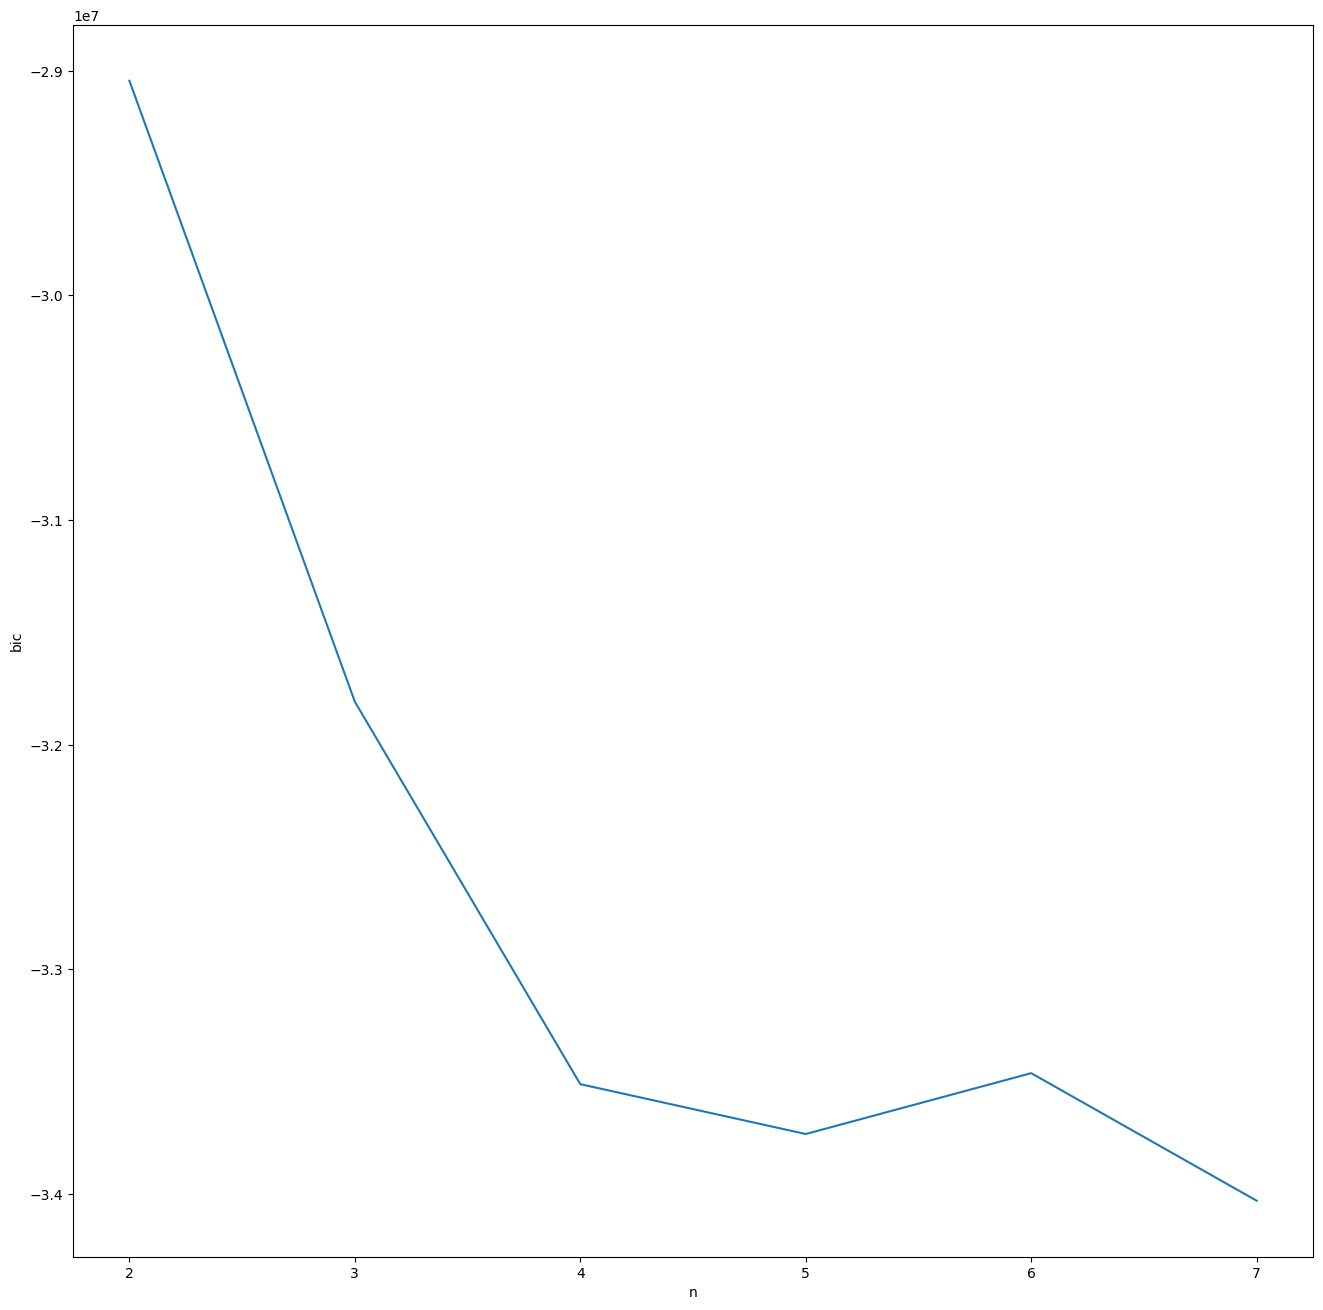

In [72]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.lineplot(ax=ax, x='n', y='bic', data=bic)
# plt.savefig('../files/complete_BIC.pdf')

### Gaussian Mixture Model

In [73]:
n = 5  # illustrative - always base the number on a reasonable estimation of the optimal number of components
n_init = 5  # more initialization, more stable clustering gets

gmm = GaussianMixture(n_components=n, covariance_type="full", max_iter=200, n_init=n_init, verbose=1)
fitted = gmm.fit(data)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged.
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged.
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged.
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged.
Initialization 4
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged.


In [74]:
labels = gmm.predict(data)

In [75]:
pd.Series(labels, index=data.index).to_csv(r"C:\Users\edoar\OneDrive\Desktop\test\cluster_labels.csv")

#### Hierachical clustering

Finally, we create hierarchical classification - taxonomy.

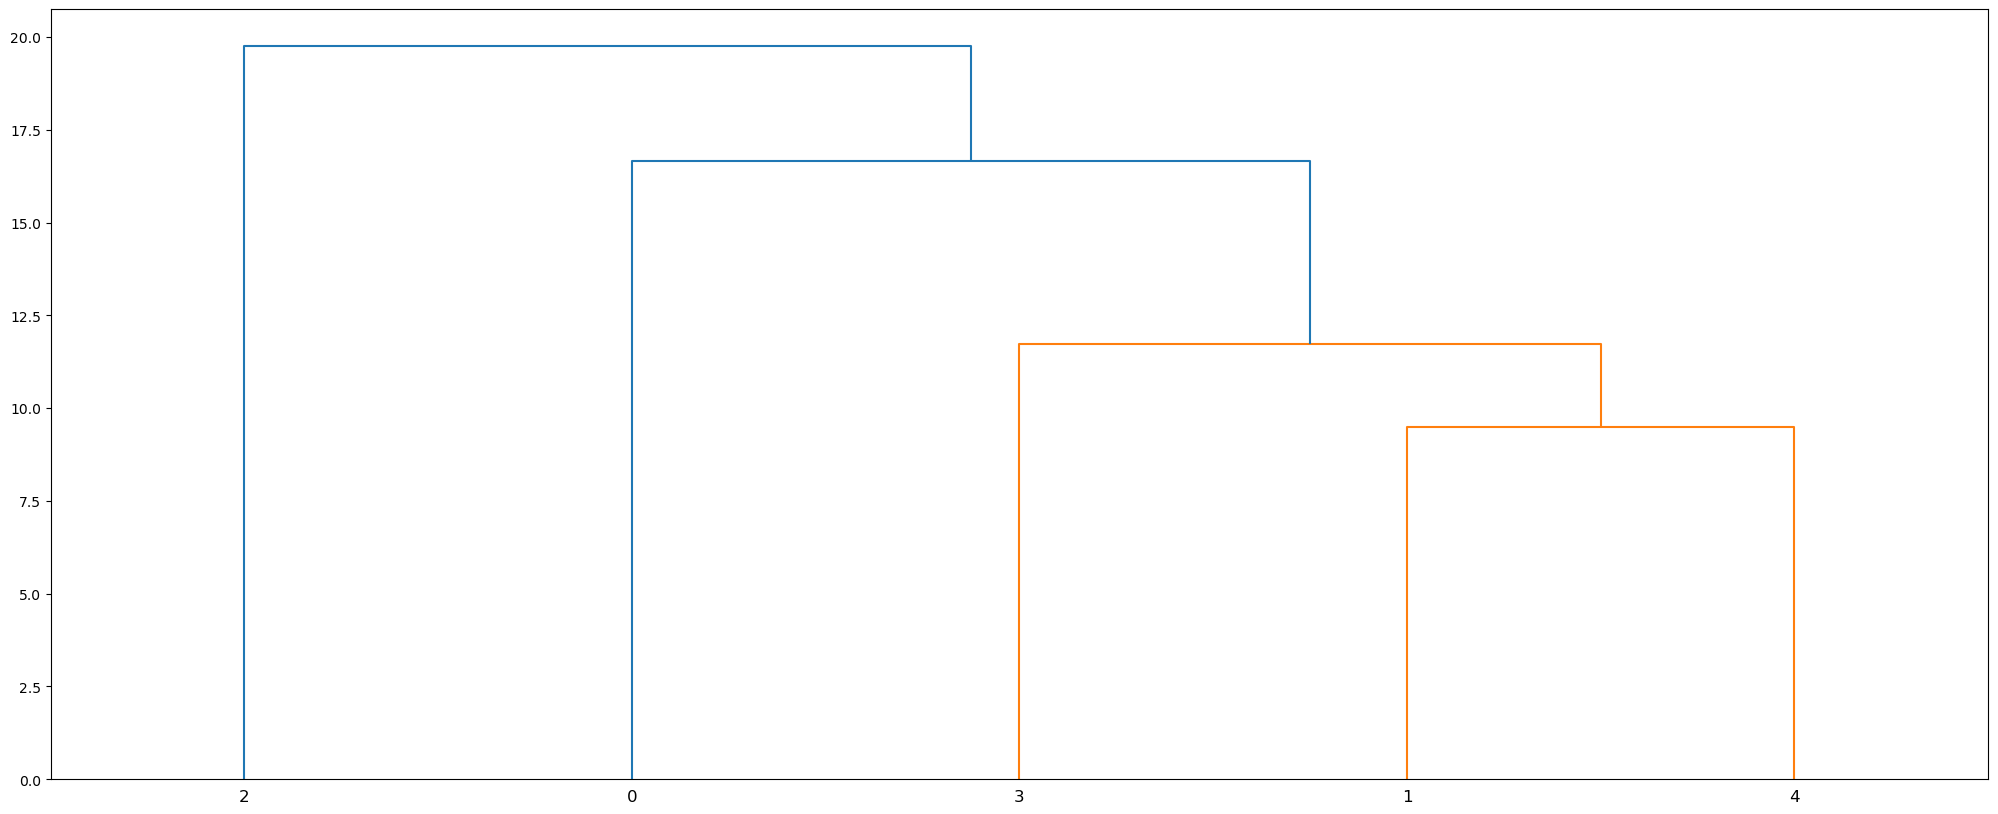

In [76]:
group = data.groupby(labels).mean()
Z = hierarchy.linkage(group, 'ward')
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z, labels=group.index)

# plt.savefig('tree.pdf')

## Results

ValueError: The dataframe and given column have different number of rows.

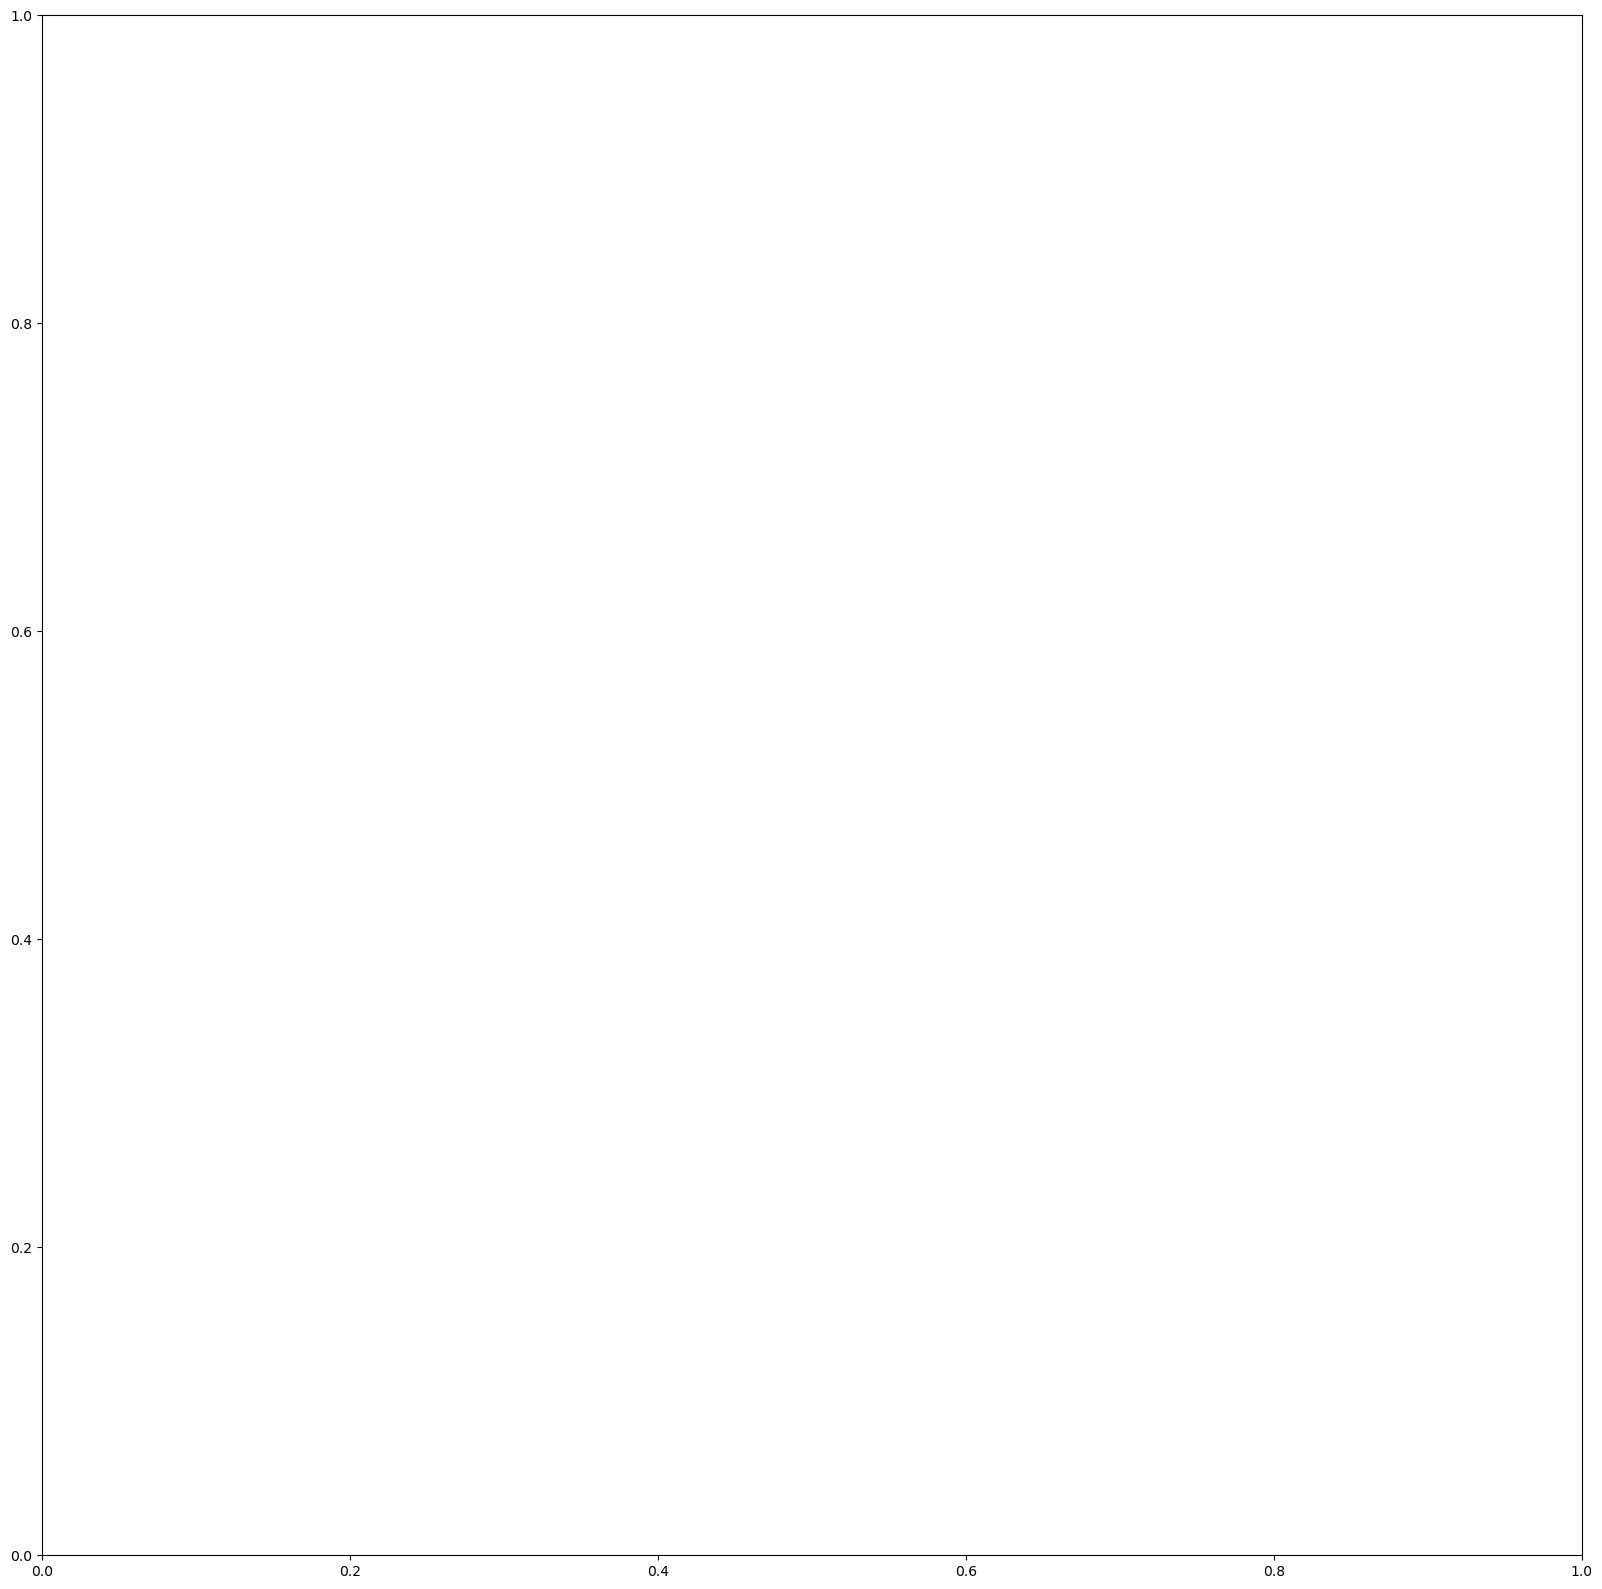

In [77]:
buildings.plot(labels, categorical=True, cmap='tab20', legend=True, figsize=(20, 20))

In [78]:
import pandas as pd

# Assuming 'labels' is currently a NumPy array or list of cluster IDs
# and it has the correct number of elements as buildings (len(labels) == len(buildings))
# If it has more elements, you will need to find which rows were dropped.

# 1. Create a Series using the buildings' index
labels_series = pd.Series(labels, index=buildings.index)

# 2. Add the series as a new column to buildings
buildings['cluster_label'] = labels_series

# 3. Plot using the new column name
buildings.plot(
    column='cluster_label',  # Use the column name
    categorical=True,
    cmap='tab20',
    legend=True,
    figsize=(20, 20)
)

ValueError: Length of values (39280) does not match length of index (39336)

In [79]:
# 1. Get the uID labels that were successfully tessellated (39280 rows)
valid_uids = tessellation['uID'].unique()

# 2. Filter the original 'buildings' GeoDataFrame to match these uIDs
# This aligns 'buildings' to the 39280 rows that were actually used for analysis.
buildings_filtered = buildings[buildings['uID'].isin(valid_uids)].copy()

# Verify the length
print(f"Filtered buildings row count: {len(buildings_filtered)}") # Should be 39280

Filtered buildings row count: 39280


<Axes: >

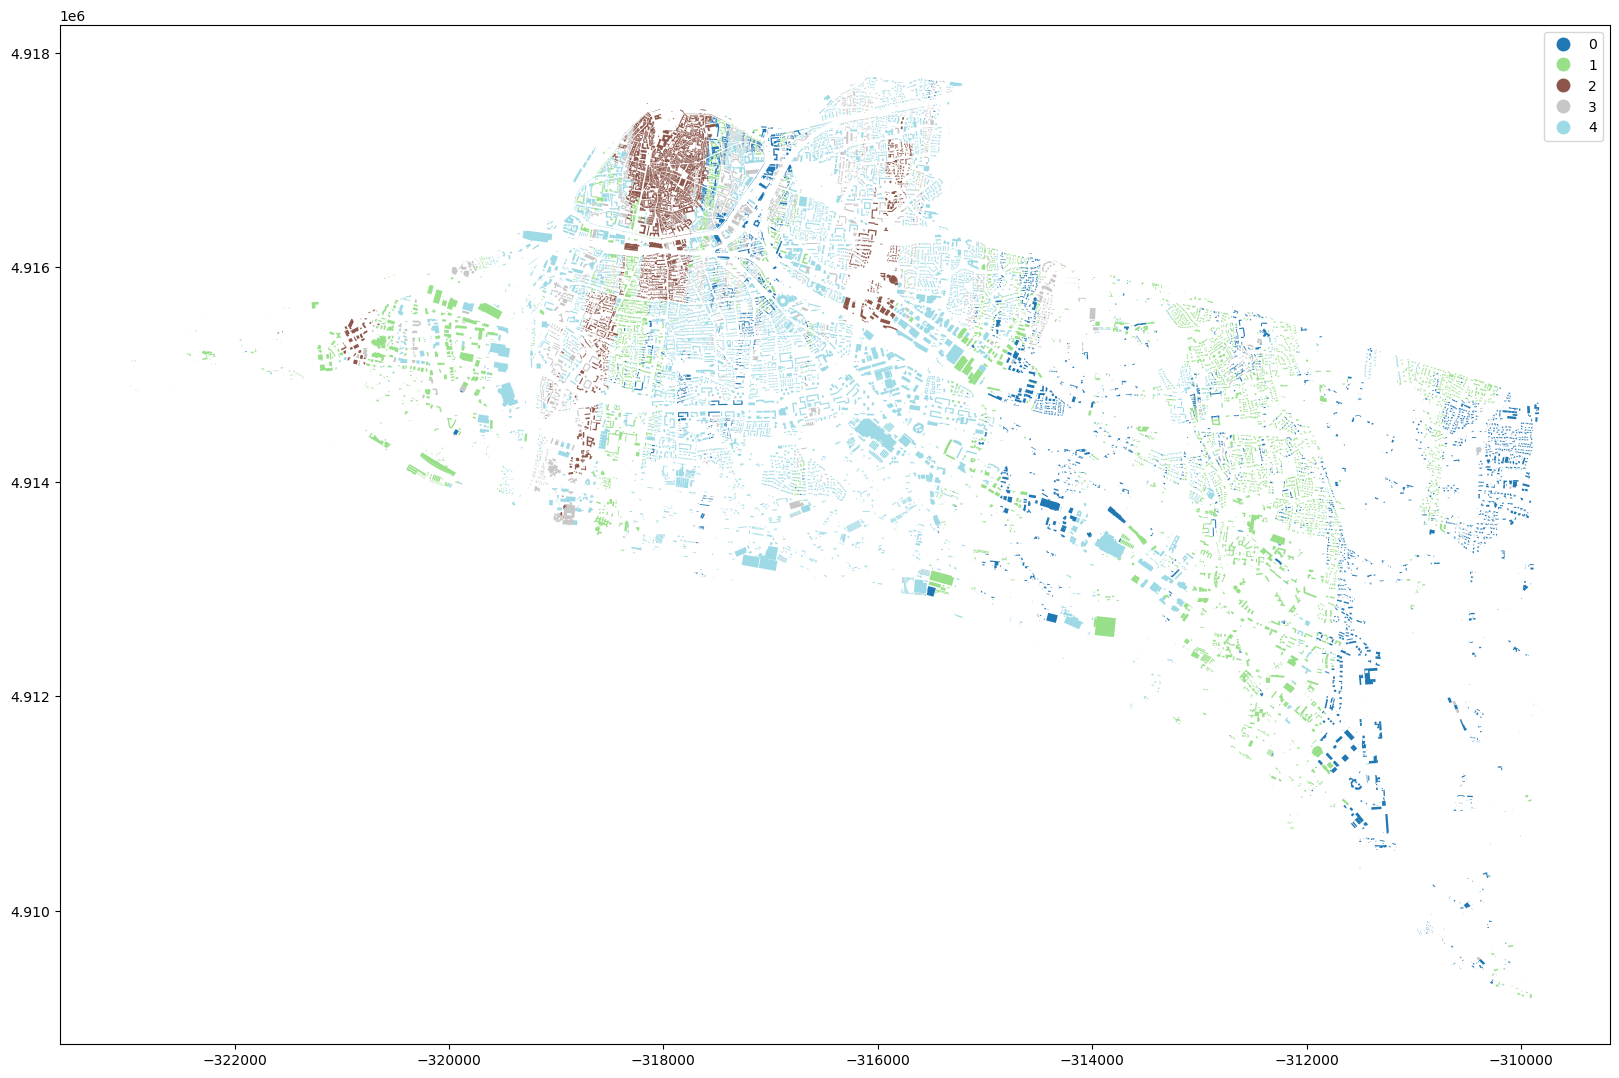

In [80]:
# Ensure labels is a Series to maintain correct index alignment, even if the index is sequential
buildings_filtered['cluster_label'] = labels

# Plot the filtered GeoDataFrame
buildings_filtered.plot(
    column='cluster_label',
    categorical=True,
    cmap='tab20',
    legend=True,
    figsize=(20, 20)
)